# **Выводы в конце ноутбука:** 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        # stdv = 1./np.sqrt(input_size)
        # self.Wx = np.random.uniform(-stdv, stdv, size=(input_size, hidden_size))
        # self.Wy = np.random.uniform(-stdv, stdv, size=(hidden_size, hidden_size))
        # self.b = np.random.uniform(-stdv, stdv, size=hidden_size)
        self.W = nn.Linear(input_size + hidden_size, hidden_size) # в качестве весов просто лин слой
        self.T = nn.Tanh()

        # self.hidden = init_hidden(self)

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)

        #W = np.dot(self.Wx, self.Wy).T

        #self.hidden = np.tanh(np.dot(np.concatenate(input_data, hidden).T, W) + self.b)
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([1, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.13223282 -0.06284315 -0.33426526  0.1857464  -0.19251004]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.27077615 -0.03183273 -0.3534962   0.28193203 -0.30477005]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# **Классификация картинок с RNN**

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K Feb  4 20:30 MNIST


Populating the interactive namespace from numpy and matplotlib


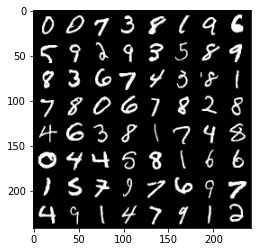

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0653,  0.0367,  0.0443,  0.0432, -0.0721,  0.0012,  0.0674, -0.1200,
         -0.0966, -0.0399],
        [ 0.0464,  0.0159,  0.0466,  0.0295, -0.0752, -0.0066,  0.0663, -0.1007,
         -0.1376, -0.0278],
        [ 0.0478,  0.0183,  0.0476,  0.0310, -0.0897, -0.0032,  0.0704, -0.1145,
         -0.1291, -0.0384],
        [ 0.0422,  0.0136,  0.0452,  0.0347, -0.0862,  0.0051,  0.0753, -0.1082,
         -0.1272, -0.0388],
        [ 0.0495,  0.0093,  0.0541,  0.0372, -0.0700,  0.0019,  0.0626, -0.0980,
         -0.1407, -0.0256],
        [ 0.0522,  0.0100,  0.0539,  0.0339, -0.0754,  0.0017,  0.0610, -0.0961,
         -0.1441, -0.0271],
        [ 0.0416,  0.0067,  0.0521,  0.0337, -0.0761, -0.0013,  0.0603, -0.0984,
         -0.1372, -0.0256],
        [ 0.0857,  0.0294,  0.0855,  0.0180, -0.0717, -0.0492,  0.0711, -0.1305,
         -0.0891, -0.0816],
        [ 0.0440,  0.0086,  0.0524,  0.0329, -0.0751, -0.0054,  0.0621, -0.0975,
         -0.1364, -0.0260],
        [ 0.0462,  

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7357 | Train Accuracy: 75.37
Epoch:  1 | Loss: 0.3086 | Train Accuracy: 91.03
Epoch:  2 | Loss: 0.2221 | Train Accuracy: 93.71
Epoch:  3 | Loss: 0.1837 | Train Accuracy: 94.76
Epoch:  4 | Loss: 0.1615 | Train Accuracy: 95.46
Epoch:  5 | Loss: 0.1460 | Train Accuracy: 95.86
Epoch:  6 | Loss: 0.1369 | Train Accuracy: 96.19
Epoch:  7 | Loss: 0.1283 | Train Accuracy: 96.43
Epoch:  8 | Loss: 0.1197 | Train Accuracy: 96.66
Epoch:  9 | Loss: 0.1190 | Train Accuracy: 96.70


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.39


# **Сентимент анализ**

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
#!pip install --pre torchtext==0.11.0 -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
#!python -m spacy download en

In [ ]:
#!pip install --pre torch==1.09.0

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy import datasets

train_data0, test_data0 = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:08<00:00, 9.78MB/s]


# start from here

In [ ]:
import copy
#train_data = copy.deepcopy(train_data0)
#test_data = copy.deepcopy(test_data0)

train_data = train_data0
test_data = test_data0

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
# ls -lh data/imdb/aclImdb/

In [ ]:
print(vars(train_data.examples[0]))

{'text': ['This', 'film', 'reminds', 'me', 'of', '42nd', 'Street', 'starring', 'Bebe', 'Daniels', 'and', 'Ruby', 'Keeler', '.', 'When', 'I', 'watch', 'this', 'film', 'a', 'lot', 'of', 'it', 'reminded', 'me', 'of', '42nd', 'Street', ',', 'especially', 'the', 'character', 'Eloise', 'who', "'s", 'a', 'temperamental', 'star', 'and', 'she', 'ends', 'up', 'falling', 'and', 'breaks', 'her', 'ankle', ',', 'like', 'Bebe', 'Daniels', 'did', 'in', '42nd', 'Street', 'and', 'another', 'performer', 'gets', 'the', 'part', 'and', 'become', 'a', 'star', '.', 'This', 'film', ',', 'like', 'most', 'race', 'films', ',', 'keeps', 'people', 'watching', 'because', 'of', 'the', 'great', 'entertainment', '.', 'Race', 'films', 'always', 'showed', 'Black', 'Entertainment', 'as', 'it', 'truly', 'was', 'that', 'was', 'popular', 'in', 'that', 'time', 'era', '.', 'The', 'Dancing', 'Styles', ',', 'The', 'Music', ',', 'Dressing', 'Styles', ',', 'You', "'ll", 'Love', 'It', '.', 'This', 'movie', 'could', 'of', 'been', 'b

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
# Сделаем словарь
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203371), (',', 192722), ('.', 166127), ('and', 109776), ('a', 109461), ('of', 100980), ('to', 94411), ('is', 76392), ('in', 61619), ('I', 54333), ('it', 53696), ('that', 49248), ('"', 43554), ("'s", 43160), ('this', 42597), ('-', 36914), ('/><br', 35751), ('was', 35314), ('as', 30499), ('with', 29921)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
# pretrained model
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 26701.26it/s]


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BestText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        ##self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # ## nn.Embedding.from_pretrained(weight)
        # nn_output_dim = hidden_dim
        # # nn.LSTM(5, 100, 1, bidirectional=True)
        # self.rnn = nn.LSTM(embedding_dim, nn_output_dim, bidirectional=True)
        # # линейный слой, который делает проекцию в 2 класса

        self.rnn = nn.RNN(embedding_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text, shape = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded.shape = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output.shape = [sent len, batch size, hid dim]
        #hidden.shape = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn1(embedded)
        output, hidden = self.rnn2(output)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

https://cnvrg.io/pytorch-lstm/ чекнуть потом, реализация LSTM

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

## Тренировка модели

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BestText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [ ]:
# INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 128
# HIDDEN_DIM = 128
# OUTPUT_DIM = 1

# num_epochs = 10 #1000 epochs
# learning_rate = 0.001 #0.001 lr

# input_size = INPUT_DIM #number of features
# hidden_size = HIDDEN_DIM #number of features in hidden state
# num_layers = 2 #number of stacked lstm layers

# num_classes = 2 #number of output classes 

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
# #model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


In [ ]:
# copy the pre-trained vectors to our embedding layer
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1687, -0.0853,  0.0486,  ..., -0.5405,  0.5309,  0.1254],
        [-0.4627,  1.2673, -0.3014,  ..., -0.1104, -1.3585,  0.5170],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.1099,  0.3633, -0.0148,  ..., -1.1893, -0.2250,  1.5677],
        [-0.5441, -0.1638, -0.3046,  ...,  0.0627,  0.6423,  1.0284],
        [-0.1031,  0.4273,  0.3356,  ..., -0.0437,  0.6056,  0.0081]])

In [ ]:
# zero the initial weights of our unknown and padding tokens
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
import torch.optim as optim

# optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    # округление к ближайшему целому round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_weights.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.384 | Train Acc: 87.84%
	 Val. Loss: 0.430 |  Val. Acc: 85.77%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.344 | Train Acc: 88.97%
	 Val. Loss: 0.449 |  Val. Acc: 86.50%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.314 | Train Acc: 89.98%
	 Val. Loss: 0.455 |  Val. Acc: 87.02%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.290 | Train Acc: 90.86%
	 Val. Loss: 0.470 |  Val. Acc: 87.54%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.270 | Train Acc: 91.50%
	 Val. Loss: 0.483 |  Val. Acc: 87.83%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.250 | Train Acc: 92.07%
	 Val. Loss: 0.497 |  Val. Acc: 87.93%
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.236 | Train Acc: 92.59%
	 Val. Loss: 0.509 |  Val. Acc: 88.20%
Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.220 | Train Acc: 93.24%
	 Val. Loss: 0.524 |  Val. Acc: 88.50%
Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.208 | Train Acc: 93.63%
	 Val. Loss: 0.533 |  Val. Acc: 88.61%
Epoch: 10 | Epoch Time: 0m 4

In [ ]:
model.load_state_dict(torch.load('best_weights.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.448 | Test Acc: 85.27%


## Вывод:

Взял предобученный embedding, оптимизатор Adam. RMSprop обычно лучше показывает себя в текстах, но по результатам эксперимента лучшим оказался Adam.

Добился точности ~85.3% на тестовой выборке датасета IMBD.